# Can we predict strain type (sativa/indica) from strain descriptions?

In [48]:
# GENERAL
import numpy as np
import pandas as pd

# NLP
from collections import Counter
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# MODELING
from sklearn import metrics, tree, linear_model, neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold

# GRAPHICS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 0. Load df, set columns

In [11]:
# LOAD df, SET COLUMNS
df_raw = pd.read_csv('data/df_strain_me_v2.csv', encoding = "UTF-8")

cols = ['strain', 'cluster', 'lean', 'strain_type', 'Strain_description']
df = df_raw[cols].copy()
df.columns = ['Strain', 'Cluster', 'Lean', 'Strain_type', 'Strain_description'] # Rename columns
df.index = df['Strain']
df.drop('Strain', axis=1, inplace=True)
df.head()

,Cluster,Lean,Strain_type,Strain_description
Strain,,,,
$100 OG,0,0.50,hybrid,$100 OG is a 50/50 hybrid strain that packs a ...
'98 Aloha White Widow,2,0.57,hybrid,The 98 Aloha White Widow is an especially pot...
1024,0,0.30,sativa,1024 is a sativa-dominant hybrid bred in Spain...
13 Dawgs,0,0.50,hybrid,13 Dawgs is a hybrid of G13 and Chemdawg genet...
22,0,0.54,hybrid,22 is a Jack Herer cross from Cali Connection....


## 1. Get the most common terms / TF-IDF for strain descriptions with Count Vectorizer

In [54]:
# SET STOPWORDS
stop_words=stopwords.words('english')

In [66]:
# INSTANTIATE COUNT VECTORIZER
# SET COUNT VECTORIZER'S TOKENIZER AS LEMMATIZER

class LemStemTokenizer(object):
    def __init__(self):
        self.lem = WordNetLemmatizer()
        self.stem = SnowballStemmer('english') # IF YOU WANT TO STEM
    def __call__(self, doc):
        # RETURN WITHOUT STEMMING W/O STOPWORDS
#         return [self.lem.lemmatize(t) for t in word_tokenize(doc) if t not in stop_words]
        # RETURN WITH STEMMING W/O STOPWORDS
        return [self.stem.stem(self.lem.lemmatize(t)) for t in word_tokenize(doc) if t not in stopwords.words('english')]

cv = CountVectorizer(tokenizer=LemStemTokenizer(), strip_accents='unicode')

In [99]:
# USE COUNT VECTORIZER TO GET TOKENS FOR ALL DESCRIPTIONS

descriptions = df['Strain_description'].fillna("") # FILL NANS

# APPLY COUNT VECTORIZER, CREATE DF WITH TOKEN COLUMNS
data_cv = cv.fit_transform(descriptions)
features = cv.get_feature_names()

# CREATE DF
data_df = pd.DataFrame(data_cv.toarray(), columns=features, index=descriptions.index)

# DROP NON-ALPHA COLUMNS
for f in features:
    if not f.isalpha():
        data_df.drop(f, axis=1, inplace=True)

In [101]:
data_df.shape

(2130, 5652)

In [102]:
data_df.head()

,abandon,abat,abbrevi,abduct,aberdeen,abil,abl,abound,absolut,abund,...,zesti,zeta,zeus,zion,zip,zippi,zkittlez,zombi,zone,zoom
Strain,,,,,,,,,,,,,,,,,,,,,
$100 OG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'98 Aloha White Widow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13 Dawgs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# NORMALZE (TF-IDF) - DIVIDE ROW BY ROW SUM

# CREATE norm_data_df (all floats)
norm_data_df = data_df.copy().astype(float)

# NORMALIZE norm_data_df
for row in range(len(norm_data_df)):
    if sum(data_df.iloc[row]) != 0:
        norm_data_df.iloc[row] /= sum(data_df.iloc[row])

In [104]:
norm_data_df.sum().head()

abandon     0.014493
abat        0.356413
abbrevi     0.012987
abduct      0.124269
aberdeen    0.081081
dtype: float64

### 1.1 Explore the data: what are the 20 most common words in strain descriptions?

In [105]:
# CREATE df_sum WHICH CONTAINS BOTH (a) ABSOLUTE TERM COUNT AND (b) TD-IDF FOR EACH TERM
# NB: df_sum CONTAINS DATA FOR ALL STRAINS

word_count = data_df.sum(axis=0)
tf_idf = norm_data_df.sum(axis=0)
data = pd.concat([word_count, tf_idf], axis=1).values
columns = ["Word_count", "TF_IDF"]

df_sum = pd.DataFrame(data=data, index=word_count.index, columns = columns)

In [106]:
# GET 20 MOST COMMON WORDS - SORT df_sum BY word_count
df_sum = df_sum.sort_values(by='Word_count', ascending=False)
df_sum.head(20)

,Word_count,TF_IDF
strain,2694.0,62.790639
effect,1431.0,32.421426
hybrid,1193.0,29.914280
cross,1035.0,25.678188
og,984.0,21.688412
kush,936.0,21.018405
aroma,903.0,20.481732
sweet,783.0,18.018880
indica,779.0,18.408976
flavor,777.0,17.996204


For the most common words it appears as though Word_count and TF-IDF are nearly identical. We can just pick one method and use it without worrying too much.

In [107]:
data_df.to_csv('leafly_decription_words.csv')

## 2. Decision Tree: train a model to predict Strain_type from word count for each strain

First, let's remove our target terms from word_count ("hybrid", "sativa", "indica") - this will help to "blind" the reviews.

In [108]:
data_df_blind = data_df.drop(labels=["hybrid", "sativa", "indica"], axis=1)

Now let's get our absolute baseline (the majority class)

In [109]:
# Hybrid / Indica / Sativa baseline
len(df[df['Strain_type']=='hybrid'])/len(df)

0.5178403755868545

If we just choose "hybrid" - the most common result - we would be right about 52% of the time. Surely we can beat this.

In [110]:
# Indica / Sativa only baseline
len(df[df['Strain_type']=='indica']) / (len(df[df['Strain_type']=='sativa']) + len(df[df['Strain_type']=='indica']))

0.5842259006815969

Similarly, if we're just examining sativa and indica strains, choosing "indica" will result in us being correct about 58% of the time.

### 2.1 Single Decision Tree: Hybrid / Indica / Sativa

In [132]:
# DECISION TREE CREATOR FUNCTION USING K-FOLDS
# THIS WILL EXPLORE OVER THE HYPER_PARAMETER: MAX_DEPTH

def DT_iterate(X, y, max_depth, class_names):
    
    DT_train_scores = [0]*max_depth
    DT_test_scores = [0]*max_depth
    
    # Generate confusion matrices for each depth
    DT_confusion_matrices = [np.zeros([len(class_names), len(class_names)])]*max_depth

    # Iterate over all depths
    for depth in range(1,max_depth+1):
    
        # USE k-folds TO GENERATE TRAIN/TEST SETS FOR CROSS-VALIDATION
        folds = KFold(n_splits = 5)
        indices = folds.split(X) # SPLIT df, "X"

        # For each fold
        for train_index, test_index in indices:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Set Train, Test X
            y_train, y_test = y[train_index], y[test_index] # Set Train, Test y
            
            # Instantiate, Fit DT_model
            DT_model = tree.DecisionTreeClassifier(max_depth = depth)
            DT_model.fit(X_train, y_train)

            # Generate predictions for confusion matrix, append to DT_confusion_matrices
            y_pred = DT_model.predict(X_test)
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
            DT_confusion_matrices[depth-1] = DT_confusion_matrices[depth-1] + confusion_matrix
    
            # Decision tree predict, evaluate, scaled by folds.n_splits-1            
            DT_train_scores[depth-1] += DT_model.score(X_train, y_train)*100/(folds.n_splits)
            DT_test_scores[depth-1] += DT_model.score(X_test, y_test)*100/(folds.n_splits)
            
    plt.figure()
    plt.plot(np.arange(1,max_depth+1), DT_train_scores, label="train")
    plt.plot(np.arange(1,max_depth+1), DT_test_scores, label="test")
    plt.xlabel("Depth")
    plt.ylabel("Accuracy score")
    plt.title("Accuracy scores for Decision Tree model")
    plt.legend()
    plt.show()
    
    return(DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices)

In [112]:
# DISPLAY CONFUSION MATRIX FOR ALL DEPTHS, PLOT WITH SEABORN HEATMAP

def display_cf_matrix(confusion_matrices, i):
    
    # DISPLAY CONFUSION MATRIX
    fontsize = 12
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confusion_matrices[i], annot=True)
    ax.set_title(f"Confusion matrix for depth {i+1}", fontsize=fontsize+4)
    ax.yaxis.set_ticklabels(class_names, fontsize=fontsize)
    ax.xaxis.set_ticklabels(class_names, fontsize=fontsize)
    plt.show()
    
    return None

Let's start our analysis by looking at a single decision tree for our three classes of strains: hybrid, indica, and sativa.

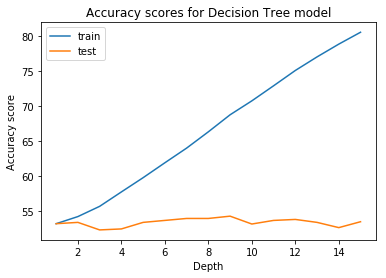

In [134]:
# ASSIGN X, y
X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

# GET DTs, SORES, CONFUSION MATRICES FOR EACH max_depth
max_depth = 15
DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices = DT_iterate(X, y, max_depth, class_names)

It looks like anything over a max depth of 2 (maybe 1) would be constitute overfitting here. I suspect that this is because we're using K-folds (previous research, run with train_test_split, had train/test track until about max_depth = 5). However, we'll need to check the confusion matrices first befoew we can decide on a reasonable depth.

Let's check the accuracy scores for depth=2:

In [114]:
print(f"TRAIN ACCURACY, MAX DEPTH = 2: {round(DT_train_scores[1],3)}")
print(f"TEST ACCURACY, MAX DEPTH = 2: {round(DT_test_scores[1],3)}")

TRAIN ACCURACY, MAX DEPTH = 2: 54.167
TEST ACCURACY, MAX DEPTH = 2: 53.333


Our DT test accuracy is about 53%. This is barely an increase on our baseline of 52% (majority class).

Let's look at the confusion matrix for this model.

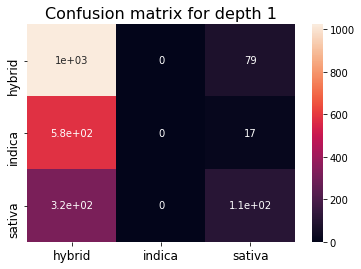

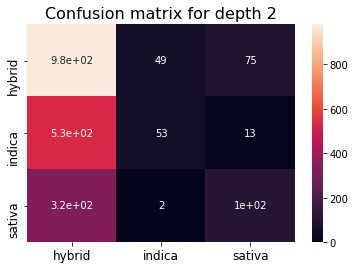

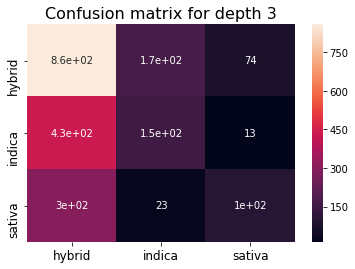

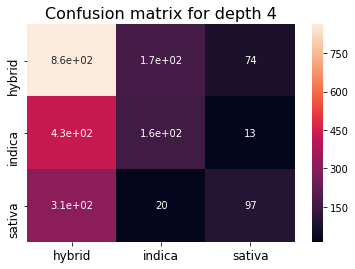

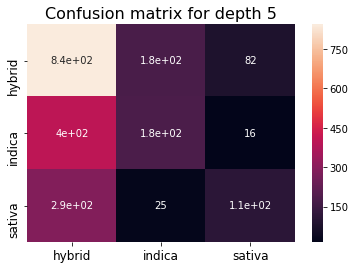

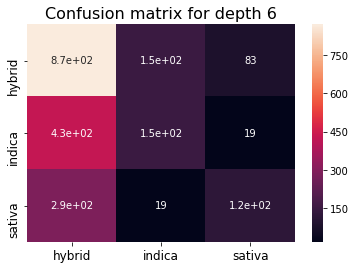

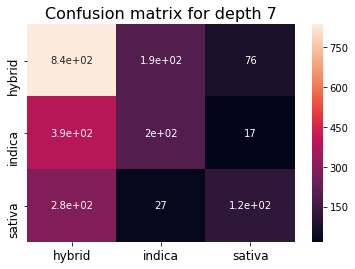

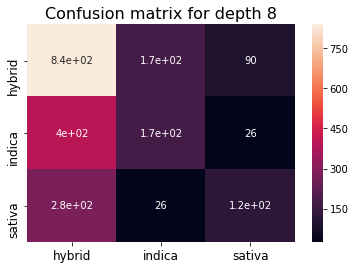

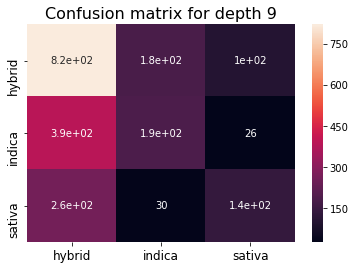

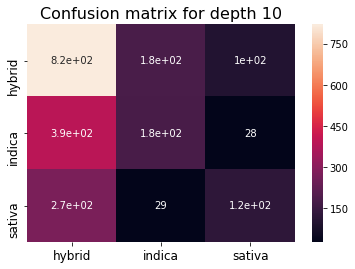

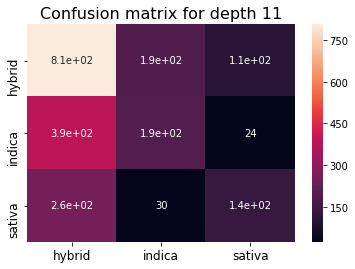

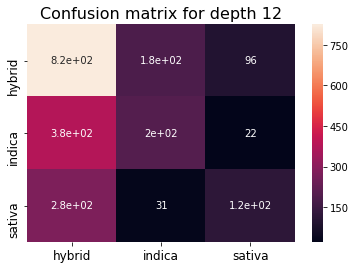

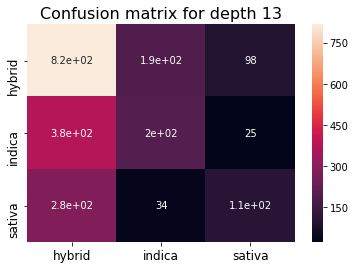

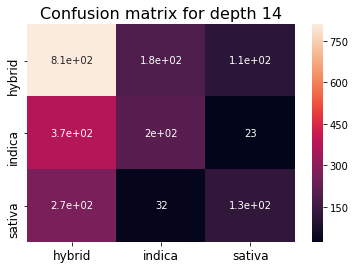

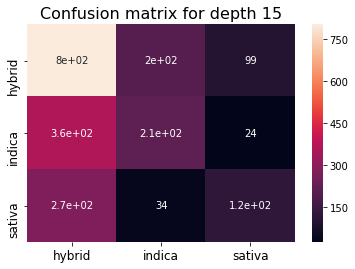

In [115]:
for i in range(0,max_depth):
    display_cf_matrix(DT_confusion_matrices, i)

It appears as our model is NOT learning to predict indica strains to a reasonable degree until at least depth 3 - depths 1 has no indica predictions at all!

That said, this model - even for higher depths - assigns more true sativas and indicas to "hybrid" than their correct class. This is a significant problem.

Interestingly, despite the confusion between hybrid and indica/sativa, there seems to be little confusion between indica and sativa. Let's see what happens if just train/predict on sativa/indica.

### 2.2 Single Decision Tree: Indica / Sativa only

In [127]:
sativa_indica_only.index

Index(['1024', '3 Bears OG', '3 Kings', '3D CBD', '3X Crazy', '501st OG',
       '8 Ball Kush', '818 OG', '831 OG', '9 Pound Hammer',
       ...
       'Yeti OG', 'Yoda OG', 'Yoda's Brain', 'Yumboldt', 'Zelly's Gift',
       'Zkittlez', 'Zombie Kush', 'Zombie OG', 'Zoom Pie', 'Alenuihaha'],
      dtype='object', name='Strain', length=1027)

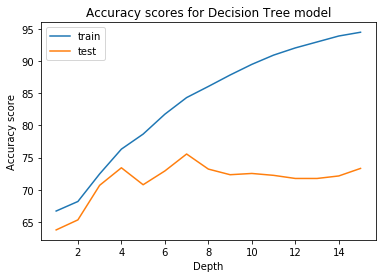

In [137]:
# DECISION TREE FOR SATIVA/INDICA ONLY

# ASSIGN X, y
sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

# GET DTs, SORES, CONFUSION MATRICES FOR EACH max_depth
max_depth = 15
DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices = DT_iterate(X, y, max_depth, class_names)

Focusing on sativa/indica is much more promising! At least our test results are increasing beyond a depth of 1.

A max depth of about 8 seems reasonable here. Let's look at accuracy scores and the confusion matrix for max depth = 8.

TRAIN ACCURACY, MAX DEPTH = 8: 86.05166685929865
TEST ACCURACY, MAX DEPTH = 8: 73.21477622543216


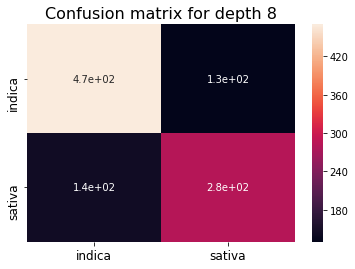

In [139]:
print(f"TRAIN ACCURACY, MAX DEPTH = 8: {DT_train_scores[7]}")
print(f"TEST ACCURACY, MAX DEPTH = 8: {DT_test_scores[7]}")
display_cf_matrix(DT_confusion_matrices, 7)

As we can see, this is a much more reasonable confusion matrix. Our accuracy for our test group is 74%, which more cleanly beats our baseline of 58%.

Now that we have results for a single decision tree, let's move onto random forests.

## 3. Random Forests: predict Strain_type from TF-IDF

As above, let's start with hybrid/indica/sativa and move on to indica/sativa.

### 3.1 Random Forest: Hybrid / Indica / Sativa

In [184]:
# RANDOM FOREST CREATOR FUNCTION USING K-FOLDS
# THIS WILL EXPLORE OVER THE HYPER_PARAMETERS : MAX_DEPTH, N_TREES

def RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=1):
    
    RF_train_scores = [0]*(max_depth-min_depth+1)
    RF_test_scores = [0]*(max_depth-min_depth+1)
    
    # Generate a confusion matrices for each depth
    # RF_confusion_matrices[n] is the list of confusion matrices for n trees
    RF_confusion_matrices = [np.zeros([len(class_names), len(class_names)])]*(max_depth-min_depth+1)
            
    # Iterate over all depths
    for depth in range(min_depth,max_depth+1):

        # USE k-folds TO GENERATE TRAIN/TEST SETS FOR CROSS-VALIDATION
        folds = KFold(n_splits = 5)
        indices = folds.split(X) # SPLIT df, "X"

        # For each fold
        for train_index, test_index in indices:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Set Train, Test X
            y_train, y_test = y[train_index], y[test_index] # Set Train, Test y

            # Instantiate, Fit RF_model
            RF_model = RandomForestClassifier(n_estimators=n_trees, max_depth=depth,\
                                          class_weight='balanced')
            RF_model.fit(X_train, y_train)

            # Generate predictions for confusion matrix, append to RF_confusion_matrices
            y_pred = RF_model.predict(X_test)
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
            RF_confusion_matrices[depth-min_depth] = RF_confusion_matrices[depth-min_depth] + confusion_matrix
            # RF predict, evaluate, scaled by folds.n_splits-1            
            RF_train_scores[depth-min_depth] += RF_model.score(X_train, y_train)*100/(folds.n_splits)
            RF_test_scores[depth-min_depth] += RF_model.score(X_test, y_test)*100/(folds.n_splits)
            
    plt.figure()
    plt.plot(np.arange(min_depth,max_depth+1), RF_train_scores, label = "train scores")
    plt.plot(np.arange(min_depth,max_depth+1), RF_test_scores, label = "test scores")
    plt.xlabel("Depth")
    plt.ylabel("Accuracy score")
    plt.title("Accuracy scores for Random Forest model")
    plt.legend()
    plt.show()
    
    return(RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices)

Let's examine our Random Forest for n_trees=200, max_depth=15.

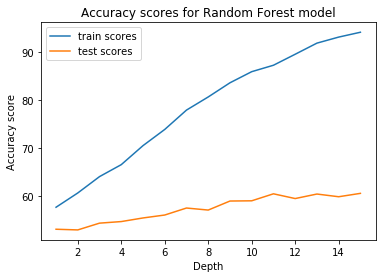

In [142]:
# Random Forest for SATIVA/INDICA/HYBRID
# n_trees = 200, max_depth = 15

X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

max_depth = 15
n_trees = 200

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names)

In [150]:
# GET TEST SCORE FOR max_depth (15)
print(f"Test score for max_depth = 15, n_trees = 200: {RF_test_scores[-1]}")

Test score for max_depth = 15, n_trees = 200: 59.71830985915493


Unlike our individual Decision Tree, our Random Forest's test data's accuracy consistently increases with depth. This is encouraging to see as it looks our model can actually learn from a greater depth.

Let's now check our confusion matrices.

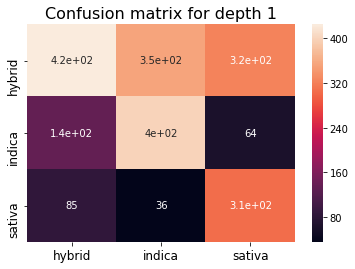

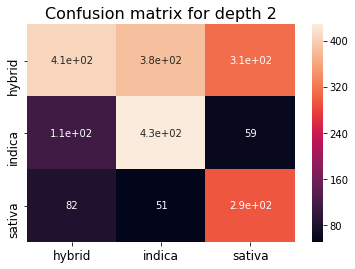

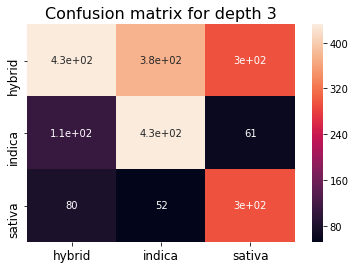

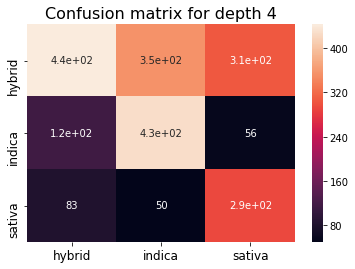

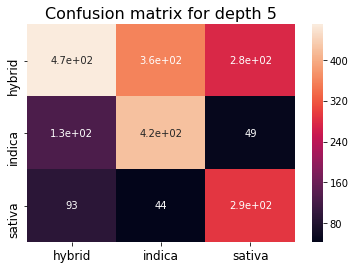

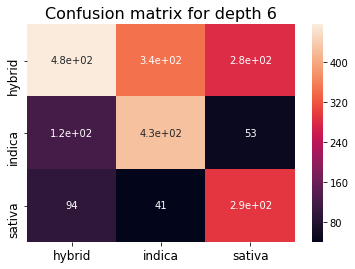

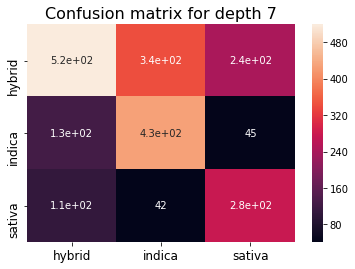

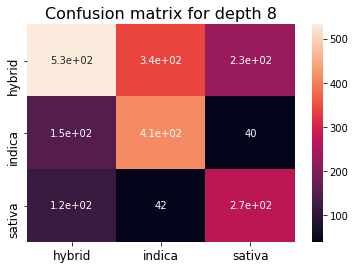

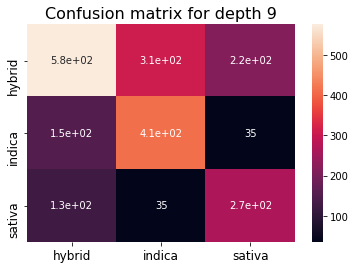

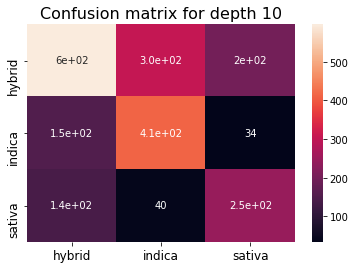

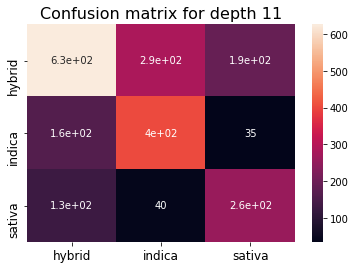

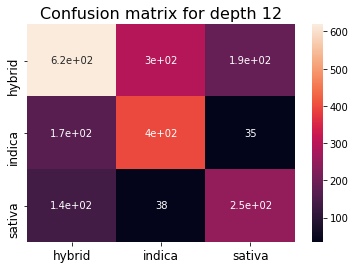

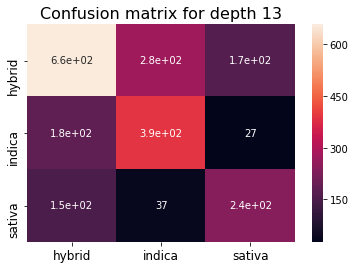

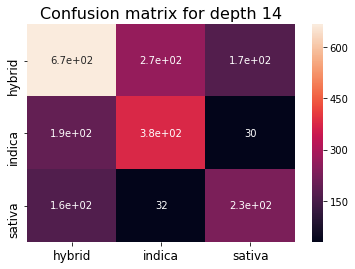

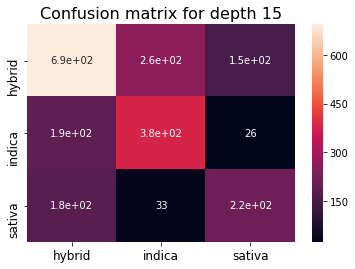

In [145]:
# Confusion Matrix
for i in range(0, max_depth):
    display_cf_matrix(RF_confusion_matrices, i)

Our confusion matrices show clear improvement for subsequent depths! Again, this is promising.

However, as with our single decision tree, our while there is little confusion between sativa and indicas, these strains are often confused with hybris.

Let's check our results for a deeper and larger Random Forest: depth=50, trees=500. We'll check two depths below and above 50 for consistency/movement.

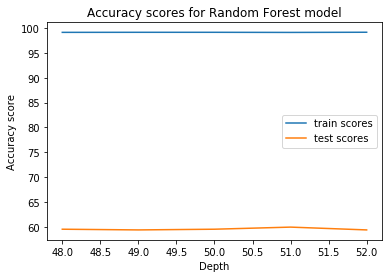

In [190]:
X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

min_depth = 48
max_depth = 52
n_trees = 500

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=min_depth)

In [194]:
print(RF_train_scores)
print(RF_test_scores)

[99.10798122065728, 99.11971830985915, 99.11971830985915, 99.09624413145539, 99.13145539906102]
[59.53051643192488, 59.38967136150235, 59.53051643192488, 59.953051643192495, 59.38967136150235]


A greater max_depth and more trees does not increase our test scores by a perceptible degree - depth=50, tree=500 is functionally equivalent to depth=15, trees=200, (from 59.5 vs 59.7, well within error/acceptible variation).

So it looks like we're topping out at around a 60% accuracy score for hybrid / indica / sativa. While this is a clear improvement on a single decision tree (53%), we will likely do better if we exclude hybrid strains and just focus on indica / sativa classification.

Let's now look at our confusion matrices.

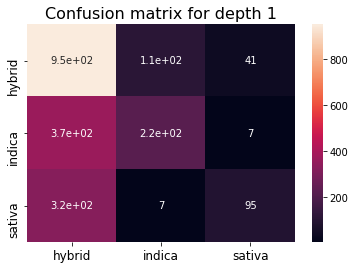

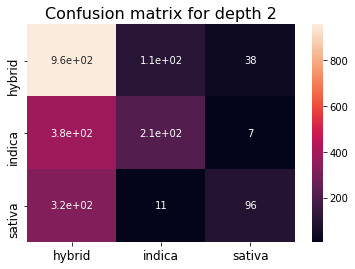

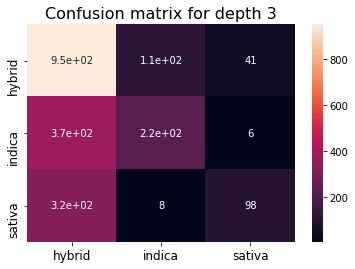

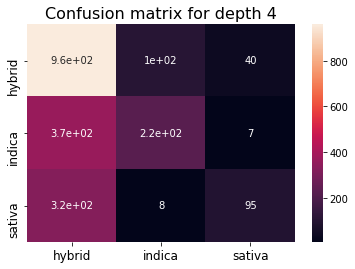

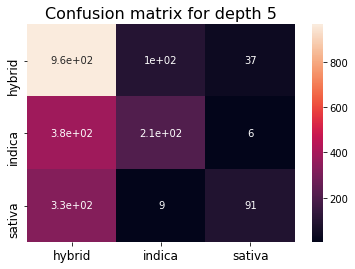

In [198]:
# Confusion Matrix
for i in range(0, max_depth-min_depth+1):
    display_cf_matrix(RF_confusion_matrices, i)

As before, more indica and sativa strains are classified as hybrid than their proper strain type. In fact, nearly all sativa strains are classified as hybrid! For better results we will surely have to look at indica/sativa only.

### 3.2 Random Forest: Indica / Sativa only

As with our decision tree, let's see if we can get obtain higher predictive accuracy by omitting "hybrid" strains. Let's also go deeper and use a max_depth of 25.

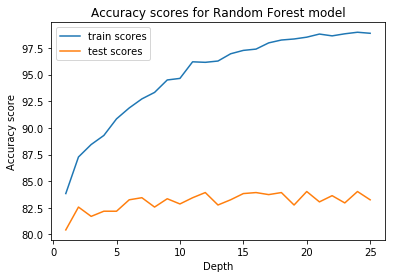

In [201]:
# Random Forest for Indica/Sativa classes, max_depth=25, n_trees = 200

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

max_depth = 25
n_trees = 200

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names)

In [211]:
np.mean(RF_test_scores[15:25])

83.530854842529

The accuracy stores start around 80 and seem to waver around 83.5%. Let's check our confusion matrices.

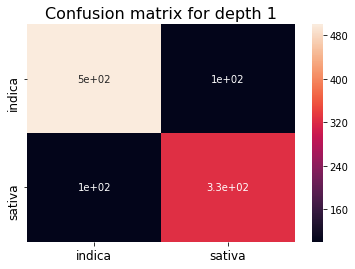

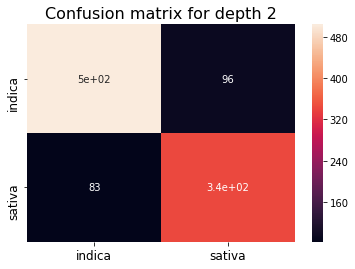

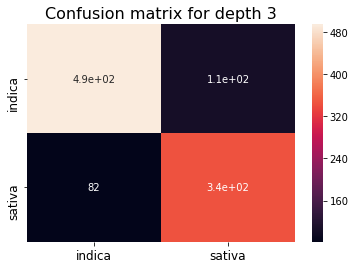

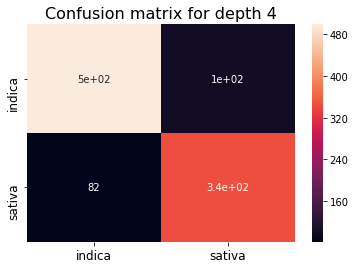

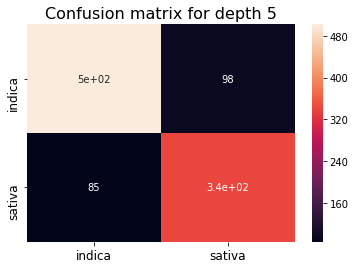

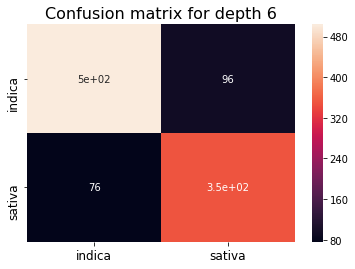

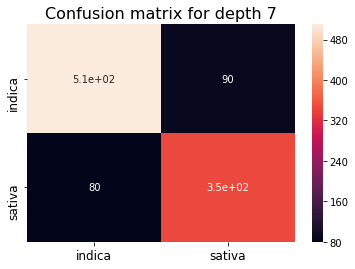

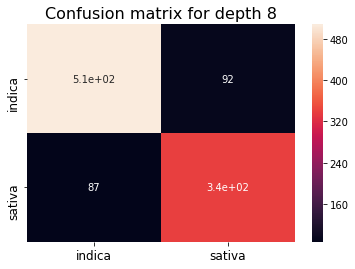

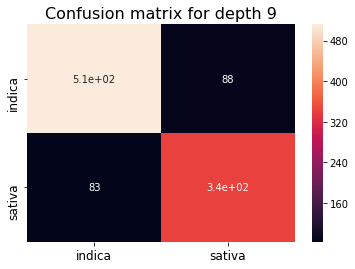

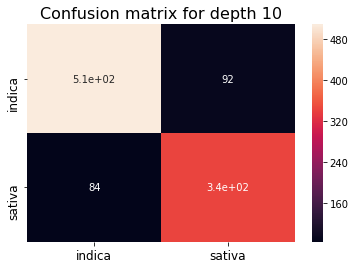

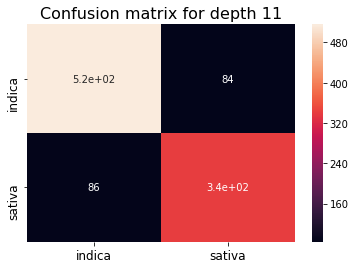

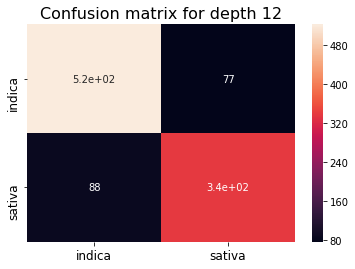

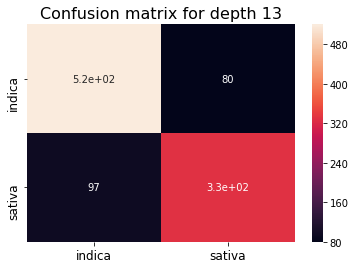

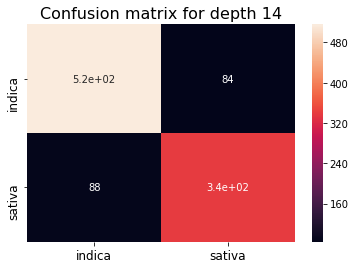

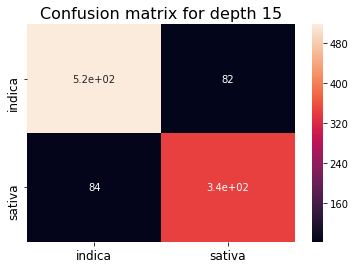

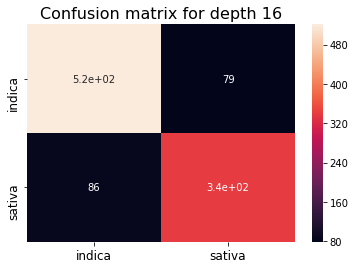

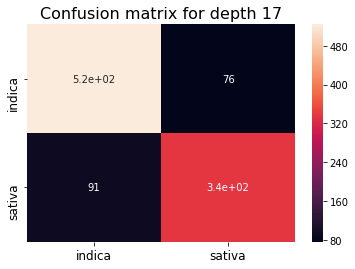

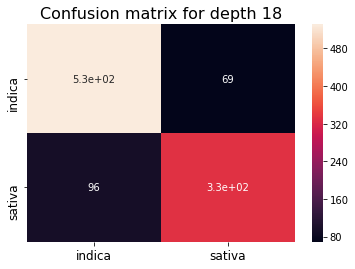

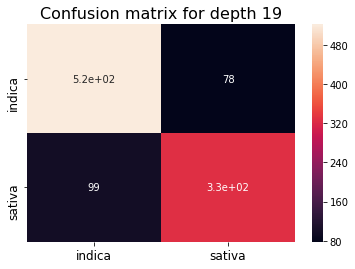

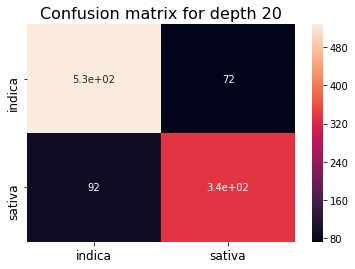

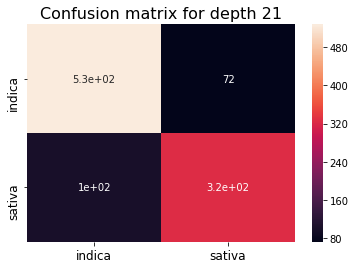

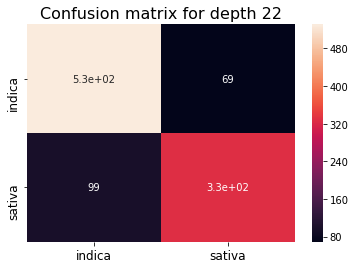

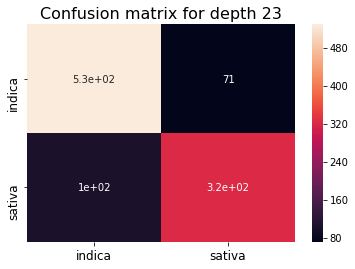

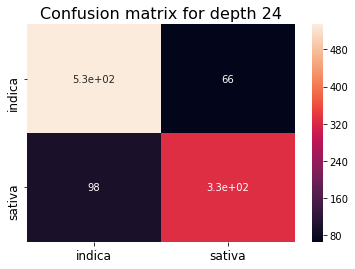

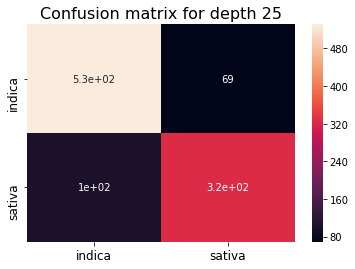

In [212]:
# Confusion Matrix
for i in range(0, max_depth):
    display_cf_matrix(RF_confusion_matrices, i)

Our confusion matrices are fairly consistent for most depths. Do we dare see if this holds for, say a depth of 50 with 500 trees, as we did for hyrbid/sativa/indica strains?

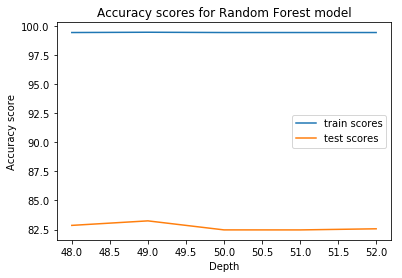

In [213]:
# Random Forest for Indica/Sativa classes, max_depth=25, n_trees = 200

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

min_depth = 48
max_depth = 52
n_trees = 500

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=min_depth)

In [215]:
np.mean(RF_test_scores)

82.72119346436183

The test scores here consistently average 82.7. Not as good as what we achieved for fewer trees at a lower depth, but at least it's consistent.

Our __BEST SCORE__ for sativa/indica only for a random forest is therefore around 83.5%, approx. 10% higher than for a single decision tree.

## 4. Most important features (terms)

What are the most critical features (terms) for our indica/sativa only RF model? Which words (or, more specifically, which lemmatized words) are helpful in distinguishing indica strains from sativa strains?

In [216]:
# EXPLORE MOST IMPORTANT FEATURES
top_features = 30

feature_list = list(data_df_blind.columns)

importances = list(RF_model.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

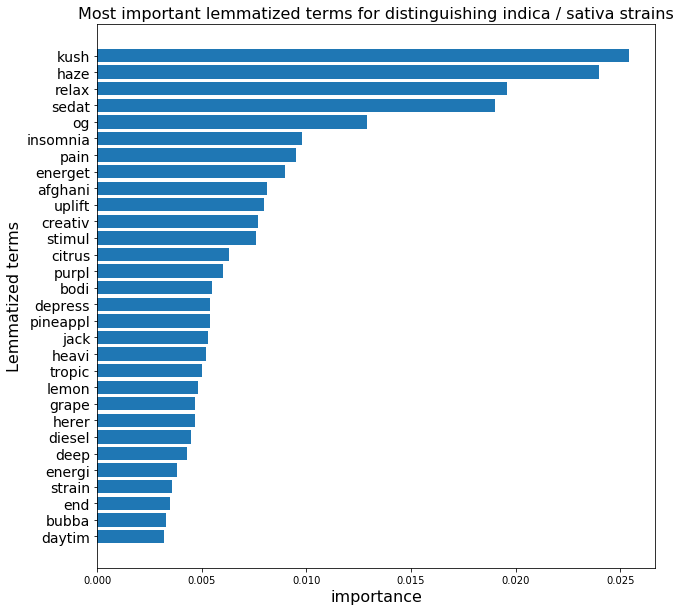

In [217]:
# VISUALIZE MOST IMPORTANT FEATURES

features = [feature_importances[i][0] for i in range(0,top_features)]
importances = [feature_importances[i][1] for i in range(0,top_features)]

plt.figure(figsize=(10,10))
plt.barh(y=features, width=importances)
plt.xlabel(xlabel="importance",fontsize=16)
plt.ylabel(ylabel="Lemmatized terms", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.title("Most important lemmatized terms for distinguishing indica / sativa strains", fontsize=16)
plt.gca().invert_yaxis()
plt.show()

From this list of terms we can immediately recognize some as being indicative of typically-associated effects, flavours, and medical uses for indica/sativa strains.

For example, indica strains are often described as relax[ing], sedat[ive], grape flavoured, and good for imsomnia and pain, while sativas are often described as energet[ic], uplift[ing], creat[ive], citrus/lemon flavoured, and good for depress[ion].

Some of the most common terms, such as "kush", "haze", and "og", likely refer to the names of the strains or their parent strains. Let's test this theory.

In [230]:
# CHECKING STRAIN TYPES FOR TERMS: "KUSH", "HAZE", "OG"
sativas = 0
indicas = 0

term_list = ["Kush", "Haze", "OG"]

for term in term_list:
    for i in sativa_indica_only.index:
        if term in i:
            if (sativa_indica_only['Strain_type'].loc[i][0]) == "s":
                sativas += 1
            else:
                indicas += 1
            
    print(f"Term: {term}\nSativas: {sativas}\nIndicas: {indicas}\nIndica:Sativa ratio: {round(indicas/sativas,1)}\n")

Term: Kush
Sativas: 10
Indicas: 86
Indica:Sativa ratio: 8.6

Term: Haze
Sativas: 58
Indicas: 86
Indica:Sativa ratio: 1.5

Term: OG
Sativas: 76
Indicas: 160
Indica:Sativa ratio: 2.1



If just dealing with sativa and indica strians, "Kush" as a term is indicative of that strain being an indica by a factor of nearly 9:1, "OG" by a factor of about 2:1, and "Haze" by 1.5:1.

Clearly our model is not just going off strain names alone (especially for more balanced terms like "haze") - this term might therefore be more useful as a distingushing feature given its use the description.

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Let's now take a moment and visualize one of our decision trees.

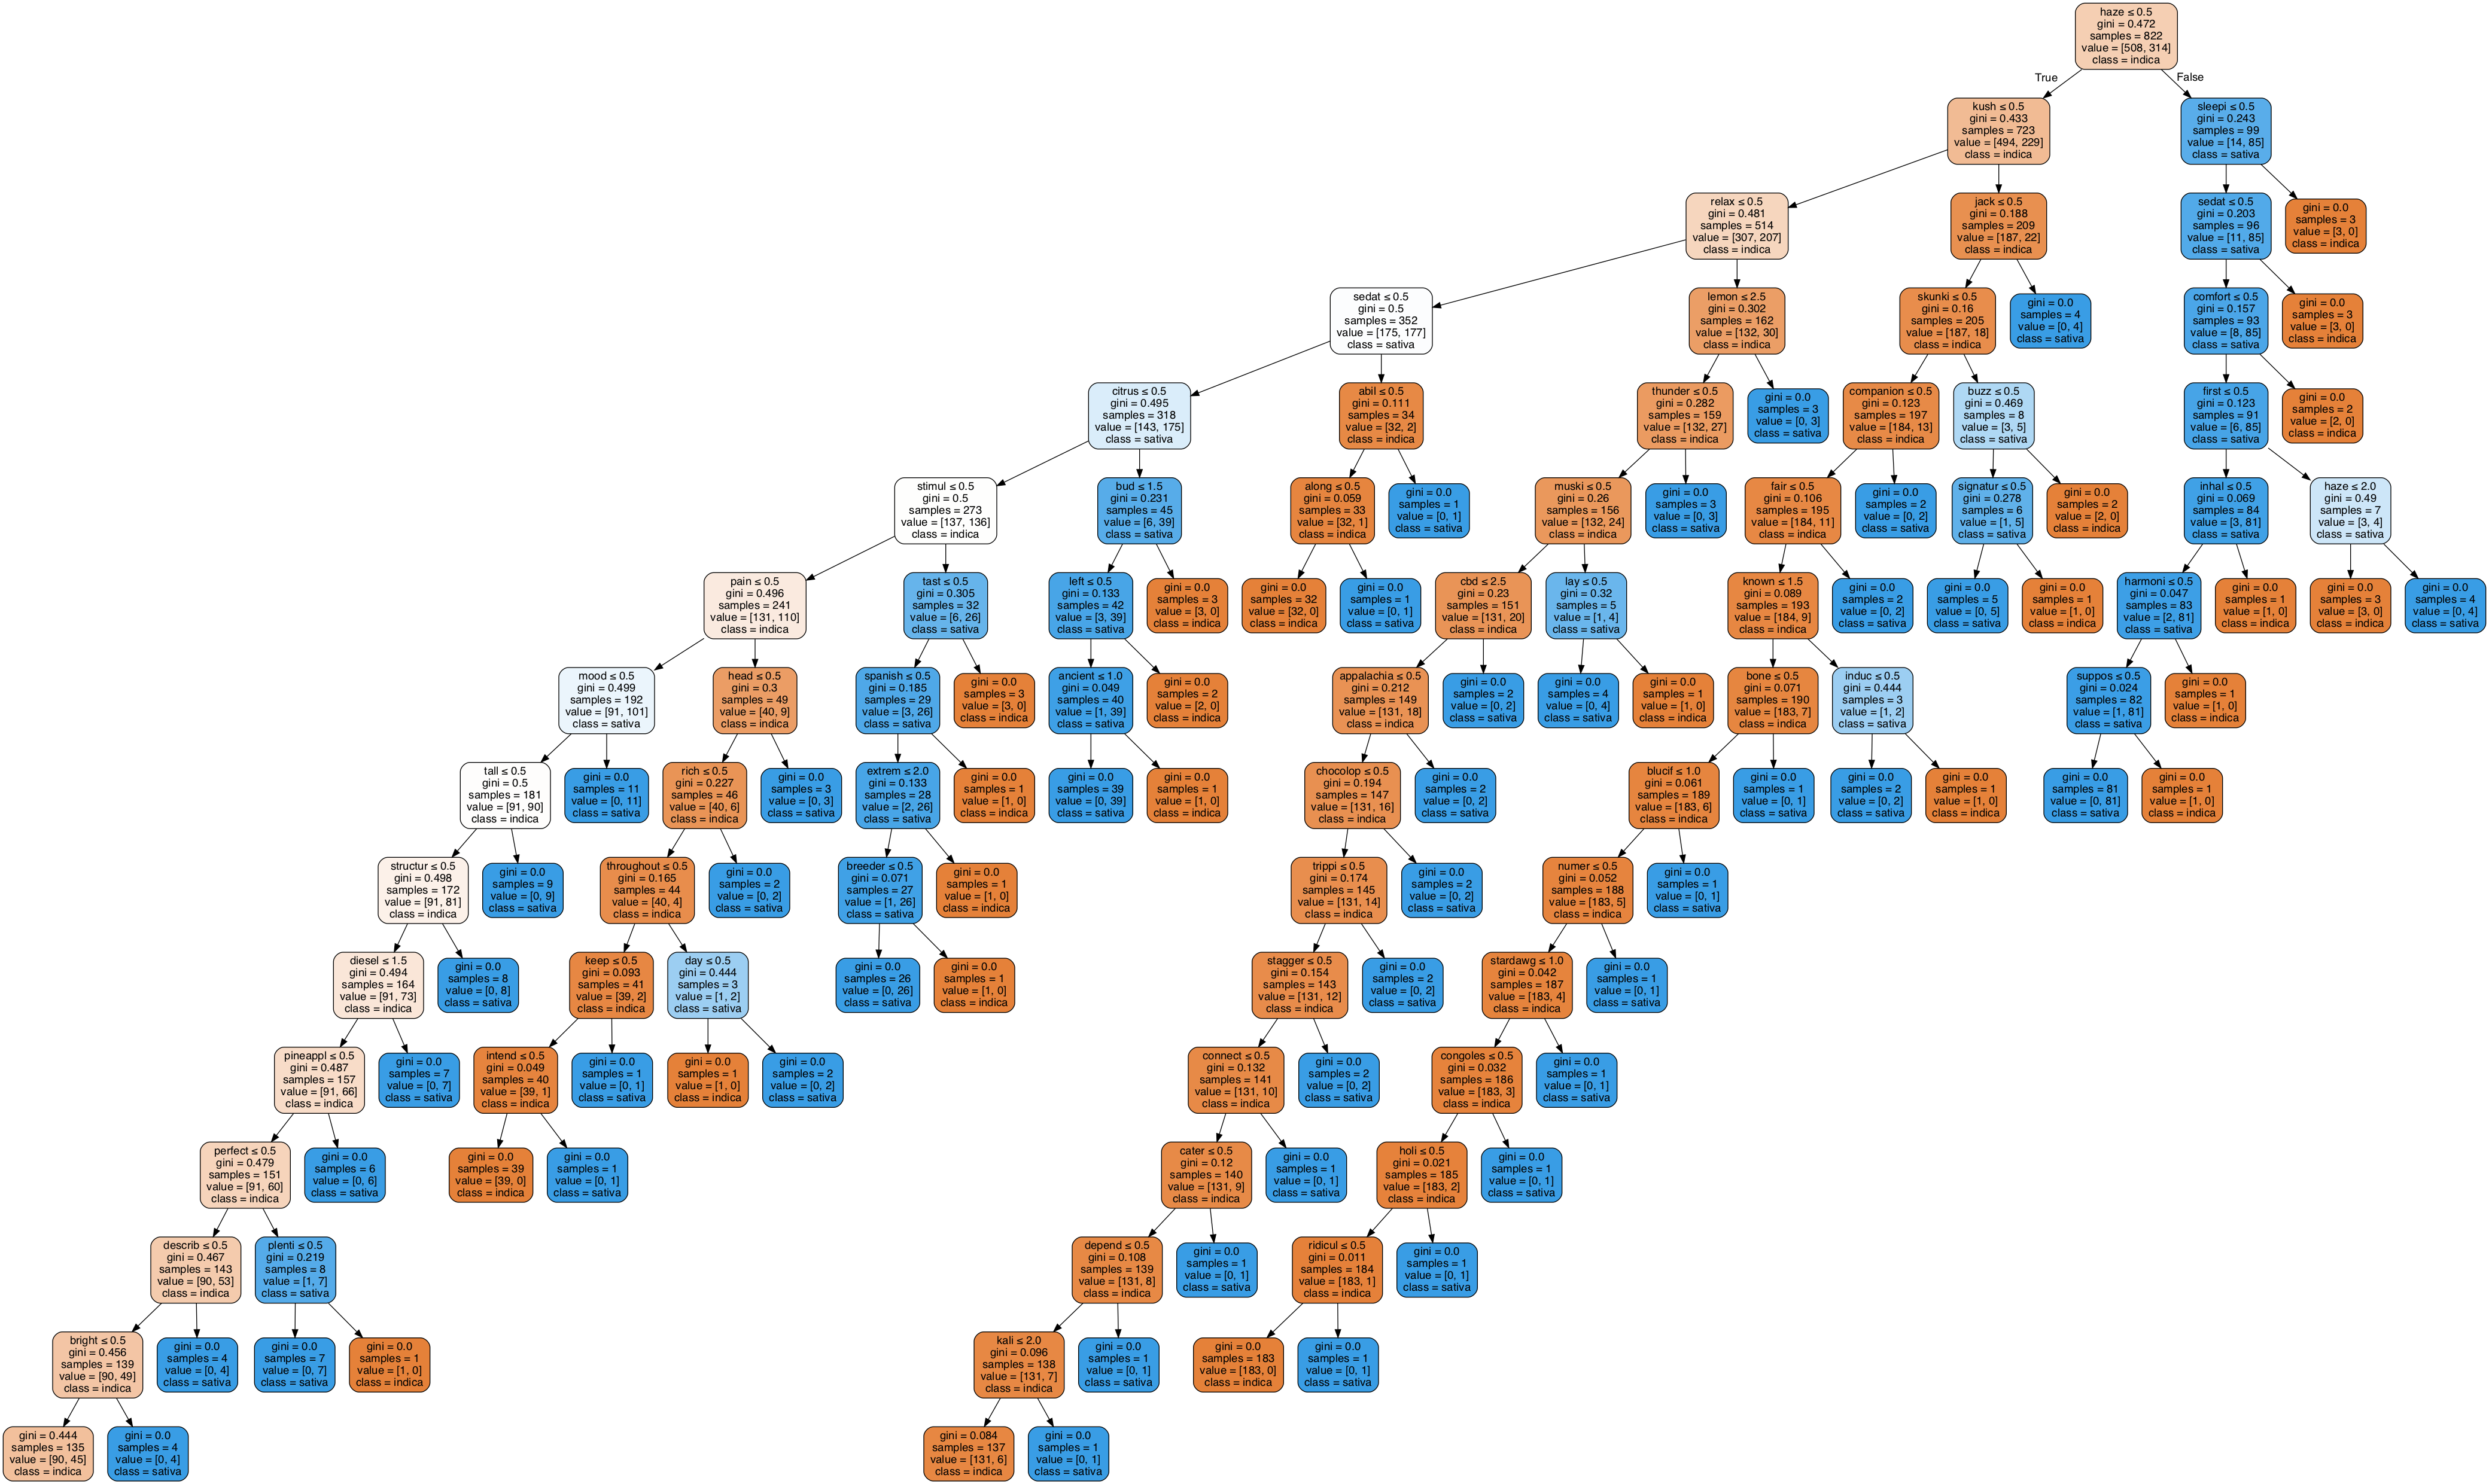

In [236]:
# VISUALIZE DECISION TREE

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(DT_model, out_file=dot_data, feature_names=data_df_blind.columns, class_names= DT_model.classes_, 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())